<a href="https://colab.research.google.com/github/jhubar/master-thesis/blob/main/XlM_btt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Install dependencies

In [1]:
!rm -r transformers
!git clone https://github.com/huggingface/transformers.git
!cd tranformers
!pip install -q ./transformers 

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 109866, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 109866 (delta 5), reused 4 (delta 1), pack-reused 109851
Receiving objects: 100% (109866/109866), 97.32 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (80141/80141), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install -q datasets seqeval

     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 212 kB 60.0 MB/s 
     |████████████████████████████████| 136 kB 77.2 MB/s 
     |████████████████████████████████| 1.1 MB 50.1 MB/s 
     |████████████████████████████████| 127 kB 59.5 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 20.5 MB/s 
     |████████████████████████████████| 271 kB 26.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=425eaf77a08f5847274fb86d1b32ba3474b790d1cee3ebf18a11edc107dee441
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 15 kB/s 
     |████████████████████████████████| 17.3 MB 1.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successf

In [4]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
path_btt_large_qv = '/content/drive/MyDrive/LayoutLMv2/final/btt'
path_folder = '/content/drive/MyDrive/LayoutLMv2/final/xlm/Base/btt/'

In [7]:

train = pd.read_pickle(path_btt_large_qv+'/pickel/train.pkl')

val = pd.read_pickle(path_btt_large_qv+'/pickel/dev.pkl')
test = pd.read_pickle(path_btt_large_qv+'/pickel/test.pkl')


## Prepare the data



In [8]:
from collections import Counter

all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'Base': 9690, 'TotAmount': 9253, 'noise': 1675527, 'tax': 9233})

In [9]:
replacing_labels = {'noise': 'O'}

In [10]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]


train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]


In [11]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)
labels = list(set(all_labels))
print(labels)
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

['Base', 'TotAmount', 'tax', 'O']
{'Base': 0, 'TotAmount': 1, 'tax': 2, 'O': 3}
{0: 'Base', 1: 'TotAmount', 2: 'tax', 3: 'O'}


In [12]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image
class BILLYDataset(Dataset):
    """Billy dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes = annotations
        self.image_dir = image_dir
        self.image_file_names = [f for f in listdir(image_dir)]
        self.processor = processor
        self.max_length = max_length
        

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        
        assert len(words) == len(boxes) == len(word_labels)
       
        word_labels = [label2id[label] for label in word_labels]
       
        # use processor to prepare everything
        encoded_inputs = processor(image, words, boxes=boxes, word_labels=word_labels,
                              padding="max_length", truncation=True, max_length=512, return_token_type_ids=True,return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs
    


In [13]:
from transformers import LayoutLMv2FeatureExtractor
from transformers import LayoutXLMTokenizer
from transformers import LayoutXLMProcessor

processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=False)

train_dataset = BILLYDataset(annotations=train,
                            image_dir= path_btt_large_qv+'/train/image/', 
                            processor=processor)
print(len(train_dataset))
val_dataset = BILLYDataset(annotations=val,
                            image_dir=path_btt_large_qv+'/dev/image/', 
                            processor=processor)
print(len(val_dataset))
test_dataset = BILLYDataset(annotations=test,
                            image_dir=path_btt_large_qv+'/test/image/', 
                            processor=processor)
print(len(test_dataset))




Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/904 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LayoutLMv2Tokenizer'. 
The class this function is called from is 'LayoutXLMTokenizerFast'.


8211
1026
1026


Next, we create corresponding dataloaders.

In [14]:
from torch.utils.data import DataLoader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
print(len(train_dataloader))
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
print(len(val_dataloader))
test_dataloader = DataLoader(test_dataset, batch_size=2)
print(len(test_dataloader))
print(len(test_dataloader)+len(test_dataloader)+len(train_dataloader))

4106
513
513
5132


## Train the model

train the model
learning rate = 5e-5 



In [15]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
 
  return results,out_label_list, preds_list

In [16]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np
print(torch.cuda.get_device_name(0))
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutxlm-base",
                                                                      num_labels=len(labels))
labels = list(set(all_labels))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
print(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)


Tesla P100-PCIE-16GB


Downloading:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.5.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.8.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv3.norm.num_batches_tracked', 'layout

cuda:0


In [17]:


val_iterator = iter(val_dataloader)
global_step = 0
num_train_epochs = 2
train_loss = []
val_loss = []
val_precision = []
val_recall = []
val_f1 = []
preds_val = None
out_label_ids = None
batch_logits_array = []
out_label_list=[]
preds_list=[]
#put the model in training mode
val_batch_idx = 0
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   loop = tqdm(train_dataloader, leave=True)
   for batch_id, batch in enumerate(loop):
        model.train() 
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        train_loss.append(loss.item())
        # writer.add_scalar("Loss/train", loss.item(), input_ids)
        loss.backward()
        optimizer.step()
        
        # Testing part
        if val_batch_idx >= len(val_iterator):
            val_iterator = iter(val_dataloader)
            val_batch_idx = 0
        val_batch_idx += 1
        model.eval()
        with torch.no_grad():
            batch = next(val_iterator)
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            image = batch['image'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            # forward pass
            outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                            token_type_ids=token_type_ids, labels=labels)
            if preds_val is None:
                preds_val = outputs.logits.detach().cpu().numpy()
                out_label_ids = batch["labels"].detach().cpu().numpy()
            else:
                preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0)
       

        
        loss = outputs.loss
        val_loss.append(loss.item())
         
        if global_step % 100 == 0 or global_step == 0:
            val_result,out_label_l,preds_l = results_test(preds_val, out_label_ids, list(set(all_labels)))
            val_precision.append(val_result['precision'])
            val_recall.append(val_result['recall'])
            val_f1.append(val_result['f1'])
            out_label_list.append(out_label_l)
            preds_list.append(preds_l)

        
            
            print("Overall results:", val_result)
            print(f"Loss after {global_step} steps: {train_loss[-1]}")
            print("Validation loss: {}".format(loss.item()))
        global_step += 1

  #  print(f"{epoch} |  | {loss:^12.6f} | {val_loss:^10.6f}  ")


model.save_pretrained(path_folder +"check_points/LargeCheckpoints_xlm_lr_1e5")
path_model = path_folder +'model/large_model_xlm_btt_qv_lr_star_1e5.pt'
torch.save(model, path_model)

# define data
data_loss = pd.DataFrame({'batch_loss_array': train_loss,'val_loss':val_loss})
data_loss.to_csv(path_folder + 'output/logits_btt_qv_large_star_lr_1e5.csv')
data_loss = pd.DataFrame({'precison':val_precision,'recall':val_recall,'f1':val_f1})
data_loss.to_csv(path_folder + 'output/metrics.csv')
data_loss = pd.DataFrame({'preds_list':preds_list,'out_label_list':out_label_list})
data_loss.to_csv(path_folder + 'output/classification_reports.csv')
# data_logits = asarray([batch_logits_array])
# save to csv file
# writer.flush()


# savetxt(path_btt_large_qv + '/logits_btt_qv_large.csv', data_logits, delimiter=',')

Epoch: 0


  0%|          | 0/4106 [00:00<?, ?it/s]

Overall results: {'precision': 0.007751937984496124, 'recall': 0.2, 'f1': 0.014925373134328356}
Loss after 0 steps: 1.2925642728805542
Validation loss: 1.0901447534561157
Overall results: {'precision': 0.13297872340425532, 'recall': 0.044563279857397504, 'f1': 0.06675567423230974}
Loss after 100 steps: 0.06634249538183212
Validation loss: 0.022168802097439766
Overall results: {'precision': 0.5141065830721003, 'recall': 0.29443447037701975, 'f1': 0.37442922374429227}
Loss after 200 steps: 0.026756970211863518
Validation loss: 0.02060243859887123
Overall results: {'precision': 0.6412859560067682, 'recall': 0.4538922155688623, 'f1': 0.5315568022440393}
Loss after 300 steps: 0.008308026008307934
Validation loss: 0.004336835350841284
Overall results: {'precision': 0.6941860465116279, 'recall': 0.5410058903488899, 'f1': 0.6080977845683728}
Loss after 400 steps: 0.047933630645275116
Validation loss: 0.005411974620074034
Overall results: {'precision': 0.7285208148804252, 'recall': 0.5957986236

  0%|          | 0/4106 [00:00<?, ?it/s]

Overall results: {'precision': 0.870081858991286, 'recall': 0.8542908996629505, 'f1': 0.8621140763997907}
Loss after 4200 steps: 0.0003261943347752094
Validation loss: 0.021597063168883324
Overall results: {'precision': 0.8717376373626373, 'recall': 0.856588493335583, 'f1': 0.8640966726236065}
Loss after 4300 steps: 0.018460310995578766
Validation loss: 0.009812022559344769
Overall results: {'precision': 0.8719207688111125, 'recall': 0.8567835051546392, 'f1': 0.8642858628507248}
Loss after 4400 steps: 0.001408562995493412
Validation loss: 0.09481778740882874
Overall results: {'precision': 0.8726475050227561, 'recall': 0.8583239232134215, 'f1': 0.8654264511538071}
Loss after 4500 steps: 0.019316866993904114
Validation loss: 0.009145203977823257
Overall results: {'precision': 0.8733913322375015, 'recall': 0.8592671478720467, 'f1': 0.8662716717035153}
Loss after 4600 steps: 0.00019833740952890366
Validation loss: 0.0007550451555289328
Overall results: {'precision': 0.8746861268047709, 're

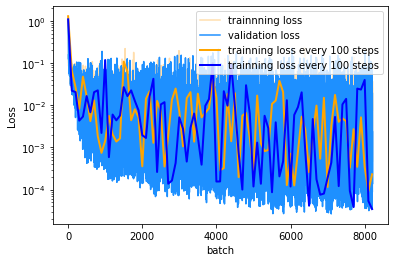

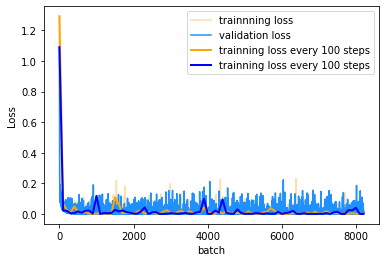

In [18]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 


# data_loss = pd.read_csv(path_btt_large_qv + '/output/logits_btt_qv_large_star_lr_1e5.csv')


x_avg_train_loss = []
y_avg_train_loss = []
x_avg_val_loss = []
y_avg_val_loss = []

x_val_precision = []
y_val_precision = []

x_avg_val_recall = []
y_avg_val_recall = []

x_avg_val_f1 = []
y_avg_val_f1 = []

for i in range(0,len(train_loss)):
   if i%100==0:
      x_avg_train_loss.append(i)
      y_avg_train_loss.append(train_loss[i]) 

for i in range(0,len(val_loss)):
   if i%100==0:
      x_avg_val_loss.append(i)
      y_avg_val_loss.append(val_loss[i]) 
      

for i in range(0,len(val_loss)):
  if i%100==0:
    try:
      x_val_precision.append(i)
      y_val_precision.append(val_precision[i])
      x_avg_val_recall.append(i)
      y_avg_val_recall.append(val_recall[i])
      x_avg_val_f1.append(i)
      y_avg_val_f1.append(val_f1[i])
    except:
      break
        

# # Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')



plt.yscale('log')
plt.xlabel('batch')
plt.ylabel('Loss')
plt.savefig(path_btt_large_qv+'/btt_qv_lr__star_1e5_log_test.png')
plt.legend()
plt.show()
# Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')

plt.xlabel('batch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path_btt_large_qv+'/btt_qv_star_lr_1e5_test.png')
plt.show()
# precision - recall - f1
# plt.plot((data_loss['precison']), label = 'val precision',color= 'navajowhite')
# plt.plot((data_loss['recall']),label = 'val recall',color='dodgerblue')
# plt.plot((data_loss['f1']),label = 'f1',color='blue')
# plt.plot((data_loss['train_loss']), label = 'trainnning loss',color= 'navajowhite')
# plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
# plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')
# plt.xlabel('epoch')
# plt.ylabel('')
# plt.legend()
# plt.savefig(path_btt_large_qv+'/btt_qv_star_lr_1e5_test.png')
# plt.show()


## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [19]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [20]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)
import numpy as np





preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
batch_test_array = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
      
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )
        


Evaluating:   0%|          | 0/513 [00:00<?, ?it/s]

In [21]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [22]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)


Overall results: {'precision': 0.9324090121317158, 'recall': 0.935326842837274, 'f1': 0.9338656483249436}
              precision    recall  f1-score   support

         ase       0.95      0.91      0.93      1013
          ax       0.92      0.97      0.94       948
    otAmount       0.93      0.93      0.93       915

   micro avg       0.93      0.94      0.93      2876
   macro avg       0.93      0.94      0.93      2876
weighted avg       0.93      0.94      0.93      2876



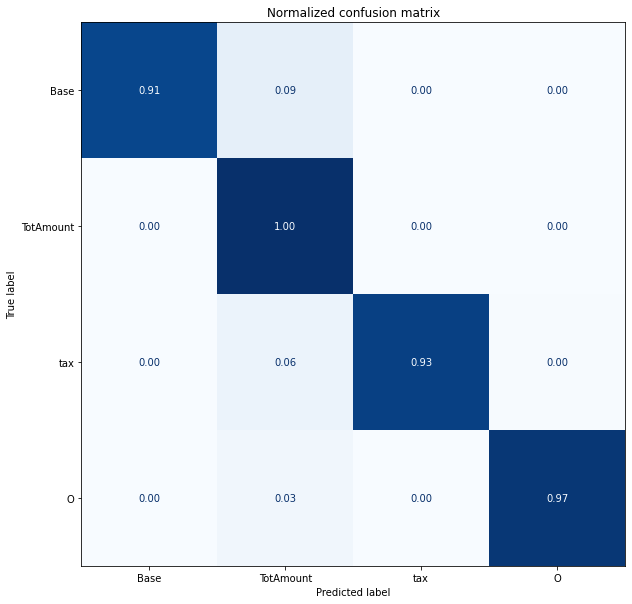

In [23]:
from matplotlib import figure
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import itertools

def plot_confusion_matrix(y_preds,y_true,labels):
  cm = confusion_matrix(y_true,y_preds,normalize= "true")
  fig, ax = plt.subplots(figsize=(10,10))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
  disp.plot(cmap="Blues",values_format=".2f",ax=ax,colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

def results_cm(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])


  return out_label_list,preds_list
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

# plot_confusion_matrix(preds_val, out_label_ids, labels)
# preds_val
out_label_list,preds_list =results_cm(preds_val, out_label_ids, labels)

out_label_list = list(itertools.chain(*out_label_list))
preds_list = list(itertools.chain(*preds_list))


plot_confusion_matrix(preds_list,out_label_list, labels)